In [1]:
# %pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'country']

def country_encoding(country):
    if country == 0:
        return 'France'
    elif country == 1:
        return 'Germany'
    else:
        return 'Spain'
    
df['country'] = df['country'].apply(country_encoding)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
skewed_columns = ['balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
# skewed_columns = ['age', 'balance', 'estimated_salary']  # 'balance'와 'estimated_salary' 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[column] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,6.429719,France,1,42,2,0.000000,1,1,1,11.526334,1
1,6.411818,Spain,1,41,1,11.336294,1,0,1,11.631096,0
2,6.220590,France,1,42,8,11.980813,3,1,0,11.643362,1
3,6.551080,France,1,39,1,0.000000,2,0,0,11.449215,0
4,6.746412,Spain,1,43,2,11.740155,1,1,1,11.278280,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

X = df[features]
y = df['churn']

X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])

print(X.head())

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

   credit_score       age  tenure   balance  products_number  credit_card  \
0      0.642408  0.324324     0.2  0.000000         0.000000            1   
1      0.622195  0.310811     0.1  0.911805         0.000000            0   
2      0.406271  0.324324     0.8  0.963645         0.666667            1   
3      0.779442  0.283784     0.1  0.000000         0.333333            0   
4      1.000000  0.337838     0.2  0.944288         0.000000            1   

   active_member  estimated_salary country  
0              1          0.929738  France  
1              1          0.940568   Spain  
2              0          0.941836  France  
3              0          0.921767  France  
4              1          0.904097   Spain  


/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_53849/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.32432432 0.31081081 0.32432432 ... 0.24324324 0.32432432 0.13513514]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])
/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_53849/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.2 0.1 0.8 ... 0.7 0.3 0.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])
/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_53849/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.       

In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc

def auc_plot(model:CatBoostClassifier, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0     0.8829    0.9627    0.9211      2389
           1     0.7747    0.5008    0.6083       611

    accuracy                         0.8687      3000
   macro avg     0.8288    0.7318    0.7647      3000
weighted avg     0.8609    0.8687    0.8574      3000



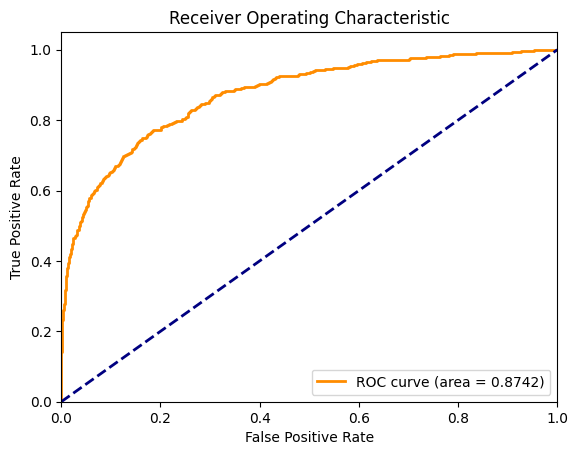

In [16]:
from sklearn.metrics import classification_report
# catboost 모델 적용
cat_features = ['country']

# CatBoost 모델 생성
cat = CatBoostClassifier(random_state=42, cat_features=cat_features, verbose=0)

# 학습
cat.fit(X_train, y_train, cat_features=cat_features, verbose=0)

# 예측
y_pred = cat.predict(X_test)

# 정확도 출력
print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

In [8]:
# param_grid = {
#     'depth': [2,3,4],
#     'learning_rate': [0.05, 0.1, 0.5],
#     'iterations': [50, 100, 150],
# }

# grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

# print('최적의 파라미터 :', grid_search.best_params_)

              precision    recall  f1-score   support

           0     0.8765    0.9682    0.9200      2389
           1     0.7895    0.4664    0.5864       611

    accuracy                         0.8660      3000
   macro avg     0.8330    0.7173    0.7532      3000
weighted avg     0.8588    0.8660    0.8521      3000



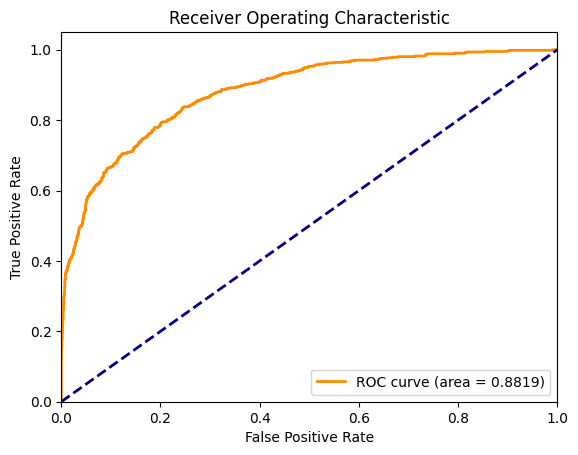

In [19]:
best_params = {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

cat = CatBoostClassifier(random_state=42, **best_params)

cat.fit(X_train, y_train, cat_features=cat_features, verbose=0)

y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

              precision    recall  f1-score   support

           0     0.9106    0.9167    0.9136      2389
           1     0.6655    0.6481    0.6567       611

    accuracy                         0.8620      3000
   macro avg     0.7881    0.7824    0.7852      3000
weighted avg     0.8607    0.8620    0.8613      3000



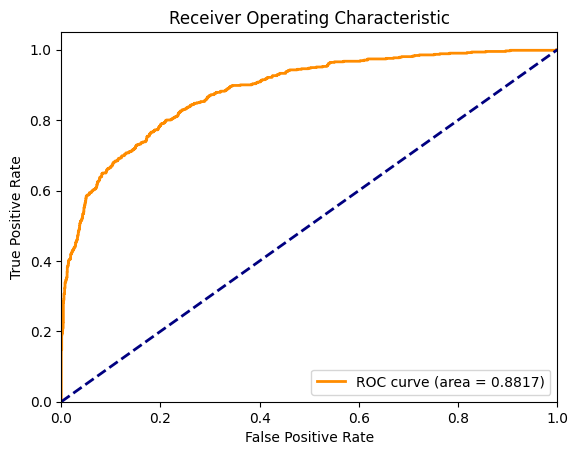

In [67]:
# 가중치 조정
# CatBoost 모델 생성
# cat = CatBoostClassifier(random_state=42, cat_features=cat_features, verbose=0, class_weights=[1, 2.211], **best_params)
# cat = CatBoostClassifier(random_state=42, cat_features=cat_features, verbose=0, class_weights=[1, 2.21], **best_params)
cat = CatBoostClassifier(random_state=42, cat_features=cat_features, verbose=0, class_weights=[1, 2.2], **best_params)

# 학습
cat.fit(X_train, y_train, cat_features=cat_features, verbose=0)

y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)